<a href="https://colab.research.google.com/github/AnandShegde/pml_baselines/blob/main/PyStan/LinearRegression_NormalLikelihood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
try:
  import pystan
except:
  %pip install -qq pystan
  import pystan
import tensorflow as tf
import numpy as np
import seaborn as sns
import numpy as np
import jax
import jax.numpy as jnp
!pip install tensorflow_probability
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import arviz as az

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [90]:
import pickle
with open("/content/LinearRegression/linear_regression_normal_distribution",'rb') as f:
    data = pickle.load(f)
data

{'data': {'x': array([[-1.4144772 ],
         [ 1.6039085 ],
         [ 2.293806  ],
         [ 3.8276772 ],
         [ 1.999692  ],
         [ 1.0609426 ],
         [ 1.2900534 ],
         [-2.3558607 ],
         [ 3.0193057 ],
         [-0.89879274]], dtype=float32),
  'y': array([ 1.2143412,  7.422146 , 10.44427  , 12.321105 ,  7.133485 ,
          6.848776 ,  6.8407617, -1.5791223, 11.820506 ,  1.6998756],
        dtype=float32)},
 'noise_variance': 1,
 'prior': {'mean': array([14. ,  7.3], dtype=float32),
  'var': array([[10.,  0.],
         [ 0., 10.]], dtype=float32)}}

In [91]:
X = data['data']['x']
Y = data['data']['y']

def identity_trans(x):
    return jnp.append(jnp.ones((m,1)),x,axis=1)
m = X.shape[0]
X = identity_trans(X)
mean_prior = data['prior']['mean']
var_prior = data['prior']['var']
diag=jnp.identity(10)

In [92]:
LinearRegression_NormalDist="""
data {
  int<lower=0> N;
  matrix[N,2] x;
  vector[N] y;
  vector[2] mean_prior;
  matrix[2,2] var_prior;
  matrix[10,10] diag;
}
parameters {
  vector[2] theta;
}
model {
  theta ~ multi_normal(mean_prior,var_prior);
  y ~ multi_normal(x*theta,diag);
}
"""

In [93]:
model_LinearReg_Normal = pystan.StanModel(model_code=LinearRegression_NormalDist)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5c729a344239304559e0a3da43070de3 NOW.


In [94]:
data = {
    'N':10,
    'x':X,
    'y':Y,
    'mean_prior':mean_prior,
    'var_prior':var_prior,
    'diag':diag
}

In [95]:
model_LinearReg_Normal_hmc = model_LinearReg_Normal.sampling(data=data, chains=8, warmup=500, iter=1500)

In [96]:
model_LinearReg_Normal_hmc

Inference for Stan model: anon_model_5c729a344239304559e0a3da43070de3.
8 chains, each with iter=1500; warmup=500; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=8000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]   4.13  5.9e-3   0.36   3.42   3.88   4.13   4.37   4.83   3632    1.0
theta[2]   2.29  2.7e-3   0.16   1.97   2.18   2.29    2.4   2.61   3576    1.0
lp__      -9.69    0.02   0.98  -12.3 -10.07  -9.39  -8.98  -8.74   3343    1.0

Samples were drawn using NUTS at Sun Jun  5 17:23:46 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5de3f1fb50>,
      dtype=object)

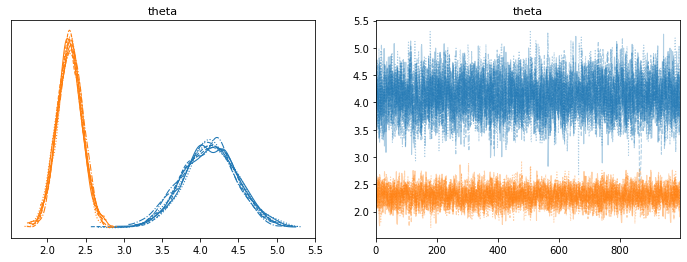

In [97]:
az.plot_trace(model_LinearReg_Normal_hmc, figsize = (12, 4))

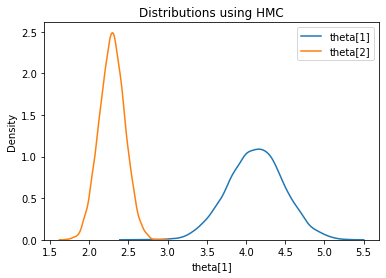

In [98]:
model_LinearReg_Normal_df = model_LinearReg_Normal_hmc.to_dataframe()
alpha_hmc = model_LinearReg_Normal_df['theta[1]']
sns.kdeplot(alpha_hmc,label="theta[1]")

beta_hmc = model_LinearReg_Normal_df['theta[2]']
sns.kdeplot(beta_hmc,label="theta[2]")

plt.title("Distributions using HMC")
plt.legend()
plt.show()

#**Using Variational Inference**

In [99]:
model_LinearReg_Normal_vi=model_LinearReg_Normal.vb(data=data)

In [100]:
model_LinearReg_Normal_vi['mean_pars']

[4.175274083891851, 2.305215842051001]

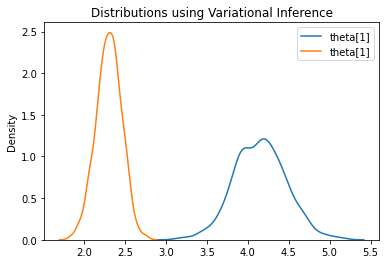

In [101]:
alpha_vi=np.array(model_LinearReg_Normal_vi.get('sampler_params')[0])
sns.kdeplot(alpha_vi,label="theta[1]")

beta_vi=np.array(model_LinearReg_Normal_vi.get('sampler_params')[1])
sns.kdeplot(beta_vi,label="theta[1]")

plt.title("Distributions using Variational Inference")
plt.legend()
plt.show()

In [102]:
def posterior(phi,m_0, t, S_0, beta, return_inverse=False):
    """Computes mean and covariance matrix of the posterior distribution."""
    S_N_inv = jnp.linalg.inv(S_0) + beta * phi.T.dot(phi)
    S_N = jnp.linalg.inv(S_N_inv)
    m_N =S_N@(jnp.linalg.inv(S_0)@m_0+beta *phi.T.dot(t))

    if return_inverse:
        return m_N, S_N, S_N_inv
    else:
        return m_N, S_N

In [103]:
mean,cov = posterior(X, mean_prior, Y, var_prior,1)

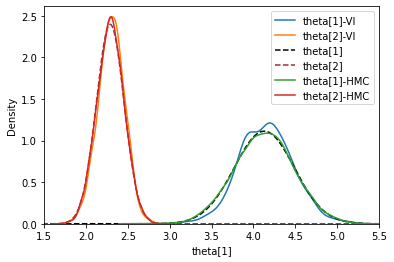

In [104]:
sns.kdeplot(alpha_vi,label="theta[1]-VI")
sns.kdeplot(beta_vi,label="theta[2]-VI")
normal1 = tfd.Normal(mean[0],jnp.sqrt(cov[0,0]))
x = jnp.linspace(1,6,1000)
pdf1 = normal1.prob(x)
plt.plot(x,pdf1,label="theta[1]",linestyle="dashed",color="black")

normal2 = tfd.Normal(mean[1],jnp.sqrt(cov[1,1]))
pdf2=  normal2.prob(x)
plt.plot(x,pdf2,label="theta[2]",linestyle="dashed",color="brown")

sns.kdeplot(alpha_hmc,label="theta[1]-HMC")
sns.kdeplot(beta_hmc,label="theta[2]-HMC")

plt.legend()
plt.xlim(1.5,5.5)
plt.show()